# Effective Graph Paper
Code to generate "thaliana" figure 

In [2]:
import os
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.2g}'.format
from IPython.display import Image, display
import graphviz
import cana
import math
from cana.boolean_network import BooleanNetwork
from cana.drawing.canalizing_map import draw_canalizing_map_graphviz
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.text import Text
from matplotlib.patches import Circle, Rectangle, RegularPolygon
from matplotlib.collections import PatchCollection
from IPython.display import display, Image, Latex, SVG, HTML
import networkx as nx
from copy import copy
#
from cana.datasets.bio import THALIANA
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler

In [3]:
def normalize(x, ab, db):
    return db[0] + (x - ab[0]) * (db[1] - db[0]) / (ab[1] - ab[0])

In [4]:
T = THALIANA()

In [19]:
SG = T.structural_graph()
EG = T.effective_graph(mode='input', bound='mean', threshold=-1)

In [20]:
dict_effconn = {nid: node.effective_connectivity(mode='node',bound='upper',norm=False) 
    for nid, node in enumerate(T.nodes,start=0) }
nx.set_node_attributes(EG, dict_effconn, 'effective_connectivity')

In [21]:
# Node Position for each one of the models
nodes = {d['label']:i for i,d in SG.nodes(data=True)}
print(nodes)
att = defaultdict(dict)
#
# Calculates Node position in a circle.
r = 2
cx = 2.5
cy = 2.5
for deg,name in zip(range(0,360,30), ['AG', 'AP3', 'PI', 'AP2', 'TFL1', 'FUL', 'AP1', 'FT', 'EMF1', 'LFY', 'SEP', 'WUS']):
    x, y = cx+r*math.cos(math.radians(deg)), cy+r*math.sin(math.radians(deg))
    att[name]['pos'] = "{x:.2f},{y:.2f}".format(x=x,y=y)
# Nodes not on the circle. Manually position them = UFO, LUG, CLF
for name,(x,y) in zip(['UFO','LUG','CLF'], [(6.0,4.5),(6.0,3.5),(6.0,2.5)]):
    att[name]['pos'] = "{x:.2f},{y:.2f}".format(x=x,y=y)
print(att)

{'AP3': 0, 'UFO': 1, 'FUL': 2, 'FT': 3, 'AP1': 4, 'EMF1': 5, 'LFY': 6, 'AP2': 7, 'WUS': 8, 'AG': 9, 'LUG': 10, 'CLF': 11, 'TFL1': 12, 'PI': 13, 'SEP': 14}
defaultdict(<class 'dict'>, {'AG': {'pos': '4.50,2.50'}, 'AP3': {'pos': '4.23,3.50'}, 'PI': {'pos': '3.50,4.23'}, 'AP2': {'pos': '2.50,4.50'}, 'TFL1': {'pos': '1.50,4.23'}, 'FUL': {'pos': '0.77,3.50'}, 'AP1': {'pos': '0.50,2.50'}, 'FT': {'pos': '0.77,1.50'}, 'EMF1': {'pos': '1.50,0.77'}, 'LFY': {'pos': '2.50,0.50'}, 'SEP': {'pos': '3.50,0.77'}, 'WUS': {'pos': '4.23,1.50'}, 'UFO': {'pos': '6.00,4.50'}, 'LUG': {'pos': '6.00,3.50'}, 'CLF': {'pos': '6.00,2.50'}})


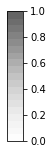

In [22]:
# ColorBar
interval = np.linspace(0.0, 0.70, 256)
colors = plt.cm.Greys(interval)
cmap = LinearSegmentedColormap.from_list('custom', colors)
#cmap = plt.get_cmap('Greys')
#cmap.set_under('white')
norm = mpl.colors.Normalize(vmin=0, vmax=1)

fig = plt.figure(figsize=(2,2))
ax = fig.add_axes([0.1, 0.05, 0.11, 0.9])
bounds = [0,0.2,0.4,0.6,0.8,1]
boundaries = np.linspace(0,1,20).tolist()

cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, boundaries=boundaries,
    extend='neither', extendfrac=.15, ticks=bounds, spacing='uniform', orientation='vertical')

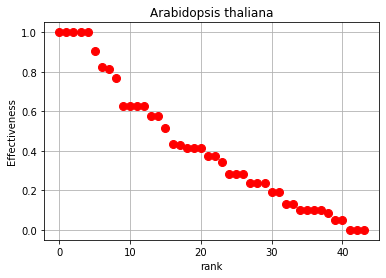

In [23]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
ys = sorted([d['weight'] for u,v,d in EG.edges(data=True) ], reverse=True)
xs = range(len(ys))
#
ax.plot(xs,ys, color='red', ms=8, marker='o', lw=2, ls='')
ax.set_title('Arabidopsis thaliana')
ax.set_ylabel('Effectiveness')
ax.set_xlabel('rank')
ax.set_ylim(-0.05,1.05)
ax.grid()
plt.savefig("figure-thaliana/thaliana-dist-e_ji.pdf", dpi=150)

In [24]:
s = pd.Series(ys)
print(s.describe())

print("Std Error: {:.2f}".format( s.sem()) )
print("Kurtosis: {:.2f}".format( s.kurtosis()) )

n_s = s.count()
n_s_gt_05 = s.loc[s>0.5].count()
n_s_gt_04 = s.loc[s>0.4].count()

print("e_ji > 0.5: {:d} ({:.2%})".format( n_s_gt_05, n_s_gt_05/n_s ) )
print("e_ji > 0.4: {:d} ({:.2%})".format( n_s_gt_04, n_s_gt_04/n_s ) )

count     44
mean    0.42
std     0.32
min        0
25%     0.13
50%     0.38
75%     0.62
max        1
dtype: float64
Std Error: 0.05
Kurtosis: -0.85
e_ji > 0.5: 16 (36.36%)
e_ji > 0.4: 21 (47.73%)


## Structural Graph

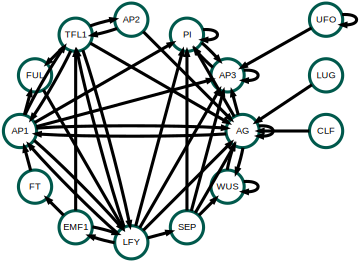

'/Users/rionbr/Sites/CANA/tutorials/2019 - Effective Graph/figure-thaliana/Thaliana-SG.svg'

In [25]:
pSG = graphviz.Digraph(name='Structural Graph', engine='neato')
pSG.attr('graph', size='5,5', concentrate='false', simplify='false', overlap='true',splines='false',ratio='auto')
pSG.attr('node', pin='true', shape='circle', fixedsize='true', width='.60', color='#00594c', style='filled', fillcolor='#515660', penwidth='4', fontname='Helvetica', fontcolor='black',fontsize='12')
pSG.attr('edge', arrowhead='normal', arrowsize='.5', color='black', penwidth='4')

for nid,d in SG.nodes(data=True):
    nid = str(nid)
    label = d['label']
    pos = att[d['label']]['pos']
    fillcolor = 'white'
    pSG.node(nid, label=label, pos=pos, fillcolor=fillcolor)

max_penwidth = 4
for uid,vid,d in SG.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    pSG.edge(uid, vid, weight=weight)
    
display(SVG(pSG.pipe(format='svg')),metadata={'isolated':True})
# Export
pSG._format = 'svg'
efile = u"{path:s}/figure-thaliana/Thaliana-SG".format(path=os.getcwd())
pSG.render(efile, cleanup=True)

## Effective Graph

In [1]:
pEG = graphviz.Digraph(name='Structural Graph', engine='neato')
pEG.attr('graph', size='5,5', concentrate='false', simplify='false', overlap='true',splines='false',ratio='auto')
pEG.attr('node', pin='true', shape='circle', fixedsize='true', width='.55', color='#ff9896', style='filled', fillcolor='#515660', penwidth='4', fontname='Helvetica', fontcolor='black',fontsize='12')
pEG.attr('edge', arrowhead='normal', arrowsize='.5', color='black', penwidth='4')

max_effoutdegree = max([v for n,v in EG.out_degree()])
list_effconn = [d['effective_connectivity'] for n,d in EG.nodes(data=True)]
min_effconn, max_effconn = min(list_effconn), max(list_effconn)
#
norm = mpl.colors.Normalize(vmin=1, vmax=max_effoutdegree)
for nid,d in EG.nodes(data=True):
    snid = str(nid)
    label = d['label']
    pos = att[d['label']]['pos']
    width = '{:.2f}'.format( normalize(d['effective_connectivity'], (min_effconn,max_effconn),(0.50,0.80) ) )
    att[d['label']]['width'] = width
    rgb = cmap(norm(EG.out_degree(nid)))
    hex = mpl.colors.rgb2hex(rgb)
    att[d['label']]['fillcolor'] = hex
    pEG.node(snid, label=label, pos=pos, width=width, fillcolor=hex)

max_penwidth = 4
for uid,vid,d in EG.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    penwidth = '%.2f' % ( d['weight']*max_penwidth )
    if d['weight'] > 0:
        rgb = cmap(d['weight'])
        hex = mpl.colors.rgb2hex(rgb)
        pEG.edge(uid,vid, weight=weight, penwidth=penwidth)
    else:
        pEG.edge(uid,vid, style='dashed', color='#A90533')
    
display(SVG(pEG.pipe(format='svg')),metadata={'isolated':True})
# Export
pEG._format = 'svg'
efile = u"{path:s}/figure-thaliana/Thaliana-EG".format(path=os.getcwd())
pEG.render(efile, cleanup=True)

NameError: name 'graphviz' is not defined

## Thresholded Effective Graph

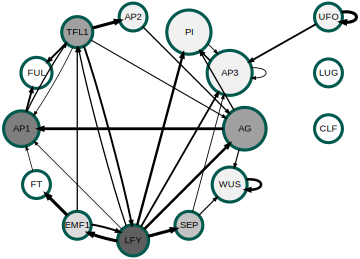

'/Users/rionbr/Sites/CANA/tutorials/2019 - Effective Graph/figure-thaliana/Thaliana-EG-t0-2.svg'

In [13]:
EGt1 = EG.copy()
threshold = 0.20
EGt1.remove_edges_from( [(u,v) for u,v,d in EGt1.edges(data=True) if d['weight']<threshold] )

pEGt1 = graphviz.Digraph(name='Structural Graph', engine='neato')
pEGt1.attr('graph', size='5,5', concentrate='false', simplify='false', overlap='true',splines='false',ratio='auto')
pEGt1.attr('node', pin='true', shape='circle', fixedsize='true', width='.55', color='#00594c', style='filled', fillcolor='#515660', penwidth='4', fontname='Helvetica', fontcolor='black',fontsize='12')
pEGt1.attr('edge', arrowhead='normal', arrowsize='.5', color='black', penwidth='4')

max_effoutdegree = max([v for n,v in EGt1.out_degree()])
list_effconn = [d['effective_connectivity'] for n,d in EGt1.nodes(data=True)]
min_effconn, max_effconn = min(list_effconn), max(list_effconn)
#
norm = mpl.colors.Normalize(vmin=1, vmax=max_effoutdegree)
for nid,d in EGt1.nodes(data=True):
    snid = str(nid)
    label = d['label']
    pos = att[d['label']]['pos']
    width = att[d['label']]['width']
    fillcolor = att[d['label']]['fillcolor']
    pEGt1.node(snid, label=label, pos=pos, width=width, fillcolor=fillcolor)

max_penwidth = 4
for uid,vid,d in EGt1.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    penwidth = '%.2f' % ( d['weight']*max_penwidth )
    rgb = cmap(d['weight'])
    hex = mpl.colors.rgb2hex(rgb)
    pEGt1.edge(uid,vid, weight=weight, penwidth=penwidth, color='black')
    
display(SVG(pEGt1.pipe(format='svg')),metadata={'isolated':True})
# Export
pEGt1._format = 'svg'
efile = u"{path:s}/figure-thaliana/Thaliana-EG-t{t:s}".format(path=os.getcwd(), t=str(threshold).replace('.','-') )
pEGt1.render(efile, cleanup=True)

In [93]:
bound = 'upper'
df = pd.DataFrame({
        'node':[n.name for n in T.nodes],
        'k':[n.k for n in T.nodes],
        'k_r':[n.input_redundancy(mode='node',bound=bound,norm=False) for n in T.nodes],
        'k_e':[n.effective_connectivity(mode='node',bound=bound,norm=False) for n in T.nodes],
        'k_r*':[n.input_redundancy(mode='node',bound=bound,norm=True) for n in T.nodes],
        'k_e*':[n.effective_connectivity(mode='node',bound=bound,norm=True) for n in T.nodes],
        'k^{out}':[v for n,v in EG.out_degree()],
        'k_e^{out}':[v for n,v in EG.out_degree(weight='weight')],
    }).set_index('node')
df = df[['k','k_r','k_e','k_r*','k_e*','k^{out}','k_e^{out}']]
df.sort_values('k',ascending=False,inplace=True)
print(df.to_latex(escape=False))

\begin{tabular}{lrrrrrrr}
\toprule
{} &  k &  k_r &  k_e &  k_r* &  k_e* &  k^{out} &  k_e^{out} \\
node &    &      &      &       &       &          &            \\
\midrule
AG   &  9 &  6.9 &  2.1 &  0.77 &  0.23 &        5 &        1.9 \\
AP3  &  7 &  4.8 &  2.2 &  0.69 &  0.31 &        2 &        0.8 \\
PI   &  6 &  3.9 &  2.1 &  0.65 &  0.35 &        2 &       0.47 \\
AP1  &  4 &  2.4 &  1.6 &  0.61 &  0.39 &        6 &        1.4 \\
LFY  &  4 &  2.8 &  1.2 &  0.69 &  0.31 &        7 &        4.8 \\
TFL1 &  4 &  2.8 &  1.2 &  0.69 &  0.31 &        5 &        2.8 \\
WUS  &  3 &  1.5 &  1.5 &   0.5 &   0.5 &        2 &       0.91 \\
FUL  &  2 & 0.75 &  1.2 &  0.38 &  0.62 &        1 &          0 \\
UFO  &  1 &    0 &    1 &     0 &     1 &        2 &        1.6 \\
FT   &  1 &    0 &    1 &     0 &     1 &        1 &       0.24 \\
EMF1 &  1 &    0 &    1 &     0 &     1 &        3 &          2 \\
AP2  &  1 &    0 &    1 &     0 &     1 &        2 &       0.43 \\
SEP  &  1 &    0 &  

In [121]:
s = df['k_e']

print(s.describe())

print("Std Error: {:.2f}".format( s.sem()) )
print("Kurtosis: {:.2f}".format( s.kurtosis()) )

count     15
mean     1.3
std     0.44
min        1
25%        1
50%      1.2
75%      1.5
max      2.2
Name: k_e, dtype: float64
Std Error: 0.11
Kurtosis: -0.32


In [123]:
s = df['k_e^{out}']

print(s.describe())

print("Std Error: {:.2f}".format( s.sem()) )
print("Kurtosis: {:.2f}".format( s.kurtosis()) )

count     15
mean     1.2
std      1.3
min        0
25%     0.34
50%      0.9
75%      1.7
max      4.8
Name: k_e^{out}, dtype: float64
Std Error: 0.33
Kurtosis: 3.39


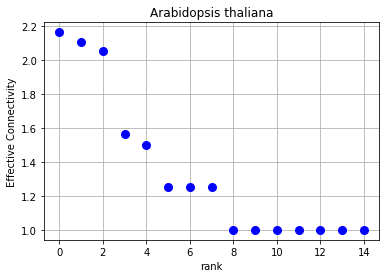

In [129]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
ys = df['k_e'].sort_values(ascending=False).values
xs = range(len(ys))
#
ax.plot(xs,ys, color='blue', ms=8, marker='o', lw=2, ls='')
ax.set_title('Arabidopsis thaliana')
ax.set_ylabel('Effective Connectivity')
ax.set_xlabel('rank')
#ax.set_ylim(-0.05,1.05)
ax.grid()
plt.savefig("figure-thaliana/thaliana-dist-k_e.pdf", dpi=150)

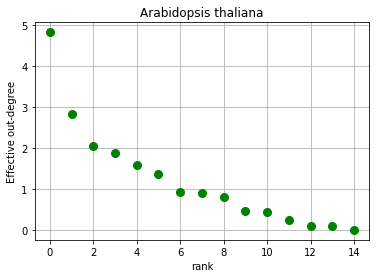

In [130]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
ys = df['k_e^{out}'].sort_values(ascending=False).values
xs = range(len(ys))
#
ax.plot(xs,ys, color='green', ms=8, marker='o', lw=2, ls='')
ax.set_title('Arabidopsis thaliana')
ax.set_ylabel('Effective out-degree')
ax.set_xlabel('rank')
#ax.set_ylim(-0.05,1.05)
ax.grid()
plt.savefig("figure-thaliana/thaliana-dist-k_e^out.pdf", dpi=150)